In [14]:
%matplotlib inline

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
import cv2
import time
import pandas as pd 
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
import pydotplus
from IPython.display import Image  

### Load train and test images into np arrays

In [3]:
start_time = time.time()

# appending all labels from data set
labels_total = []
img_dir=glob.glob('/Users/jun/UChicago/Winter 18/Data Mining/Final/fruits-360/Training/*')
labels_total={d:i for i,d in enumerate(np.unique([label.split("/")[-1] for label in img_dir]))}

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.006880998611450195 seconds ---


In [4]:
start_time = time.time()

# upload train data from local folder and separte them into two arrays(images, labels)
images_train = []
labels_train = []
img_dir=glob.glob('/Users/jun/UChicago/Winter 18/Data Mining/Final/fruits-360/Training/*')

for label in img_dir:
    fruit_label = label.split("/")[-1]
    
    for img_dir in glob.glob(os.path.join(label, "*.jpg")):
        labels_train.append(labels_total[fruit_label])
        image = cv2.imread(img_dir)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images_train.append(image.flatten())

images_train = np.array(images_train)
labels_train = np.array(labels_train)

print("the number of test images : {}".format(labels_train.shape[0]))
print("--- %s seconds ---" % (time.time() - start_time))

the number of test images : 28736
--- 17.766883850097656 seconds ---


In [5]:
images_train.shape

(28736, 30000)

In [6]:
start_time = time.time()

# upload test data from local folder and separte them into two arrays(images, labels)
images_test = []
labels_test = []
img_dir2 = glob.glob('/Users/jun/UChicago/Winter 18/Data Mining/Final/fruits-360/Validation/*')

for label in img_dir2:
    fruit_label = label.split("/")[-1]
    
    for img_dir2 in glob.glob(os.path.join(label, "*.jpg")):
        labels_test.append(labels_total[fruit_label])
        image = cv2.imread(img_dir2)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images_test.append(image.flatten())

images_test = np.array(images_test)
labels_test = np.array(labels_test)

print("the number of test images : {}".format(labels_test.shape[0]))
print("--- %s seconds ---" % (time.time() - start_time))

the number of test images : 9673
--- 5.880757808685303 seconds ---


### Run decision trees in multiple depth to find out the highest accuracy score

In [7]:
start_time = time.time()

# calculate accuracy score using different number of depth in Decision Tree
tree_accuracy= []
for i in range(30,50,2):
    tree = DecisionTreeClassifier(max_depth=i)
    tree_fit = tree.fit(images_train, labels_train)
    pred = tree.predict(images_test)
    tree_accuracy.append(accuracy_score(labels_test, pred))

print("--- %s seconds ---" % (time.time() - start_time))

--- 6067.363837003708 seconds ---


The highest accuracy score for Decision tree : 0.7778


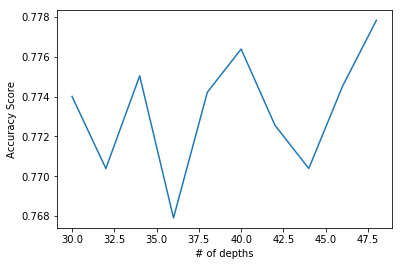

In [25]:
plt.plot(range(30,50,2), tree_accuracy)
plt.xlabel('# of depths')
plt.ylabel("Accuracy Score")

print("The highest accuracy score for Decision tree : {:.4f}".format(max(tree_accuracy)))

depth = 48 gives the highest accuracy score

##### Run Decision tree with optimal model and fit test images for accuracy score

In [9]:
start_time = time.time()

tree_opt = DecisionTreeClassifier(max_depth=48)
tree_opt_fit = tree_opt.fit(images_train, labels_train)
tree_prediction = tree_opt.predict(images_test)
tree_opt_accuracy = accuracy_score(labels_test,tree_prediction)

print("Decision Tree accuracy score : {:.4f}".format(tree_opt_accuracy))
print("--- %s seconds ---" % (time.time() - start_time))


Decision Tree accuracy score : 0.7769
--- 618.9901418685913 seconds ---


### Run Random Forest with different numbers of estimators to find the highest accuracy score on validation set

In [10]:
start_time = time.time()

# create RandomForest classifier
test_accuracy_random = {}

for i in range(10,200, 10):
    forest = RandomForestClassifier(n_estimators=i, n_jobs=4, )
    forest.fit(images_train, labels_train)
    test_predict = forest.predict(images_test)
    test_accuracy_random[i]=accuracy_score(labels_test, test_predict)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 1416.775928735733 seconds ---


Text(180,0.96,'(190,0.96)')

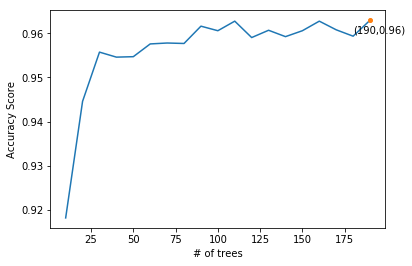

In [95]:
plt.plot(test_accuracy_random.keys(), test_accuracy_random.values())
plt.xlabel("# of trees")
plt.ylabel("Accuracy Score")
plt.plot(190,max_rf,'.', markersize=8)
plt.text(180,0.960,'(190,0.96)')

In [31]:
max_rf = max(test_accuracy_random.values())
print("the highest accuracy score : {:.4f} ".format(max_rf))
print("the number of estimators : 190")

the highest accuracy score : 0.9630 
the number of estimators : 190


### Run PCA to reduce datset

In [67]:
start_time = time.time()

# create PCA classifier
pca_clf = PCA(n_components = 200)
pca_train = pca_clf.fit(images_train)


print("--- %s seconds ---" % (time.time() - start_time))

--- 122.03192901611328 seconds ---


Total variance explained by 200 features : 0.9492
Total variance explained by 100 features : 0.9207


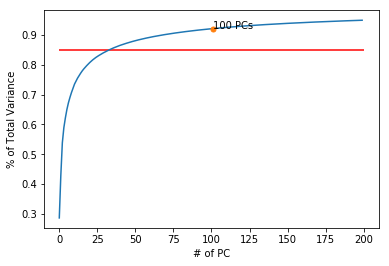

In [69]:
total_variance_train = sum(pca_train.explained_variance_ratio_)

print("Total variance explained by 200 features : {:.4f}".format(total_variance_train))
print("Total variance explained by 100 features : {:.4f}".format(sum(pca_train.explained_variance_ratio_[0:101])))

# plot cumsum of explained variance
plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
plt.xlabel('# of PC')
plt.ylabel('% of Total Variance')
plt.hlines(0.85,0,200,colors='r', label='85%')
plt.text(101,sum(pca_train.explained_variance_ratio_[0:101]),'100 PCs')
plt.plot(101,sum(pca_train.explained_variance_ratio_[0:101]),'.',markersize=10)

In [70]:
# transform original data with 6075 dimensions into 100 dimensions
start_time = time.time()

# create PCA classifier
pca_clf = PCA(n_components = 100)
pca_train = pca_clf.fit(images_train)
pca_train_transform = pca_train.transform(images_train)
print("--- %s seconds ---\n" % (time.time() - start_time))

print("original dimension : {}".format(images_train.shape))
print("transformed dimension : {}".format(pca_train_transform.shape))

--- 107.23161792755127 seconds ---

original dimension : (28736, 30000)
transformed dimension : (28736, 100)


In [73]:
sum(pca_train.explained_variance_ratio_)

0.920160349313879

In [74]:
start_time = time.time()

# transform test images using PCA
pca_test_transform = pca_train.transform(images_test)

print("--- %s seconds ---" % (time.time() - start_time))

--- 3.2997162342071533 seconds ---


### Run Decision Trees using reduced dataset

In [78]:
start_time = time.time()

# calculate accuracy score using different number of depth in Decision Tree
tree_accuracy_pca= []
for i in range(30,50,2):
    tree = DecisionTreeClassifier(max_depth=i)
    tree_fit = tree.fit(pca_train_transform, labels_train)
    pred = tree.predict(pca_test_transform)
    tree_accuracy_pca.append(accuracy_score(labels_test, pred))

print("--- %s seconds ---" % (time.time() - start_time))

--- 53.81926989555359 seconds ---


the highest accuracy score for Decision tree : 0.7305903029049933


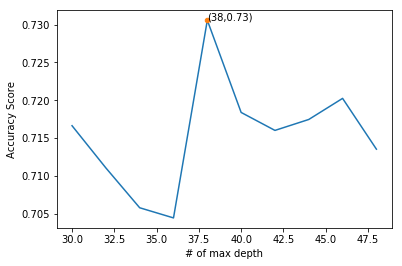

In [97]:
plt.plot(range(30,50,2), tree_accuracy_pca)
plt.xlabel('# of max depth')
plt.ylabel('Accuracy Score')
plt.plot(38, max(tree_accuracy_pca),'.', markersize=9)
plt.text(38,max(tree_accuracy_pca),'(38,0.73)')

print("the highest accuracy score for Decision tree : {}".format(max(tree_accuracy_pca)))

In [98]:
start_time = time.time()

tree_opt_pca = DecisionTreeClassifier(max_depth=38)
tree_opt_fit_pca = tree_opt_pca.fit(pca_train_transform, labels_train)
tree_prediction_pca = tree_opt_fit_pca.predict(pca_test_transform)
tree_opt_accuracy_pca = accuracy_score(labels_test,tree_prediction_pca)

print("Decision Tree accuracy score : {:.4f}".format(tree_opt_accuracy_pca))
print("--- %s seconds ---" % (time.time() - start_time))


Decision Tree accuracy score : 0.7133
--- 5.754754066467285 seconds ---


### Run random forest using PCA dataset and plot accuracy score on validation set

In [99]:
start_time = time.time()

# create RandomForest classifier
test_accuracy_random_pca = {}

for i in range(10,200, 10):
    forest = RandomForestClassifier(n_estimators=i, n_jobs=4, )
    forest.fit(pca_train_transform, labels_train)
    test_predict = forest.predict(pca_test_transform)
    test_accuracy_random_pca[i]=accuracy_score(labels_test, test_predict)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 229.4860978126526 seconds ---


Text(150,0.915125,'(150,0.9151)')

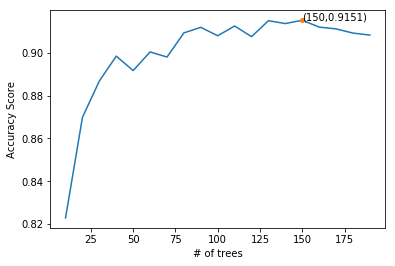

In [107]:
plt.plot(test_accuracy_random_pca.keys(), test_accuracy_random_pca.values())
plt.xlabel("# of trees")
plt.ylabel("Accuracy Score")
plt.plot(150,max_rf_pca,'.', markersize=8)
plt.text(150,max_rf_pca,'(150,0.9151)')

In [104]:
max_rf_pca = max(test_accuracy_random_pca.values())
print("the highest accuracy score : {:.4f} ".format(max_rf_pca))
print("the number of estimators : 150")

the highest accuracy score : 0.9151 
the number of estimators : 150


### Run SVM using reduced dataset

In [108]:
start_time = time.time()

# run SVM using reduced dataset and rbf kernel function
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1] }
svm_clf_2 = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm_train_2 = svm_clf_2.fit(pca_train_transform, labels_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 15265.390626192093 seconds ---


In [109]:
print("Best estimator found by grid search:")
svm_clf_2.best_estimator_

Best estimator found by grid search:


SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [110]:
pca_test_transform = pca_train.transform(images_test)
svm_pred_2 = svm_train_2.predict(pca_test_transform)

In [111]:
accuracy_score(labels_test,svm_pred_2)

0.0632688927943761

In [112]:
svm_train_2

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)